In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
import numpy as np
from astropy.table import Table
from astropy.units import Quantity
import corner
import matplotlib.pyplot as plt

## Lensed quasar population

This notebook shows how to simulate lensed quasar population.

In [2]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define a sky area
source_sky_area = Quantity(value=5, unit="deg2")
deflector_sky_area = Quantity(value=5, unit="deg2")
full_sky_area = Quantity(value=500, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 27, "z_min": 0.01, "z_max": 5}
kwargs_source_cut = {"z_min": 0.1, "z_max": 5.0}

#make galaxy-galaxy population class using LensPop
quasar_lens_pop = LensPop(
    deflector_type="all-galaxies",
    source_type="quasars",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=None,
    source_sky_area=source_sky_area,
    deflector_sky_area=deflector_sky_area,
    sky_area=full_sky_area,
    cosmo=cosmo,
)

/Users/narayankhadka/slsim/slsim/lens_pop.py:238: UserWarning: The provided light profile single_sersic is not used to describe the point source. The relevant light profile is None.
  self._sources = PointSources(


In [3]:
sample_source=quasar_lens_pop._sources._point_source_select

In [ ]:
quasar_lens_pop.deflector_number, quasar_lens_pop.source_number

## Create a source population for full sky area (this is just for plotting purpose)

In [6]:
index=np.random.randint(0, len(sample_source), size=quasar_lens_pop.source_number,
                         dtype=int)

In [8]:
total_source=Table({
    'z': [], 'M': [], 'ps_mag_i': []
})
for i in index:
    total_source.add_row(sample_source[i])

## Draw lenses

In [11]:
kwargs_lens_cuts = {}
# drawing population
quasar_lens_population = quasar_lens_pop.draw_population(speed_factor=1000,
    kwargs_lens_cuts=kwargs_lens_cuts)

## Extract necessary quantities of each lens

In [12]:
print("Number of lenses:", len(quasar_lens_population))

lens_samples2 = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]
source_z=[]
deflector_z=[]
sigma_v=[]
m_s=[]
for ps_lens in quasar_lens_population:
    source_mag = min(ps_lens.point_source_magnitude(band="i", lensed=True))
    vel_disp = ps_lens.deflector_velocity_dispersion()
    m_star = ps_lens.deflector_stellar_mass()
    theta_e = ps_lens.einstein_radius
    zl = ps_lens.deflector_redshift
    zs = ps_lens.source_redshift
    deflector_mag = ps_lens.deflector_magnitude(band="i")
    source_z.append(zs)
    deflector_z.append(zl)
    sigma_v.append(vel_disp)
    m_s.append(source_mag)
    lens_samples2.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag]
    )

Number of lenses: 607


## Plot lens quantities

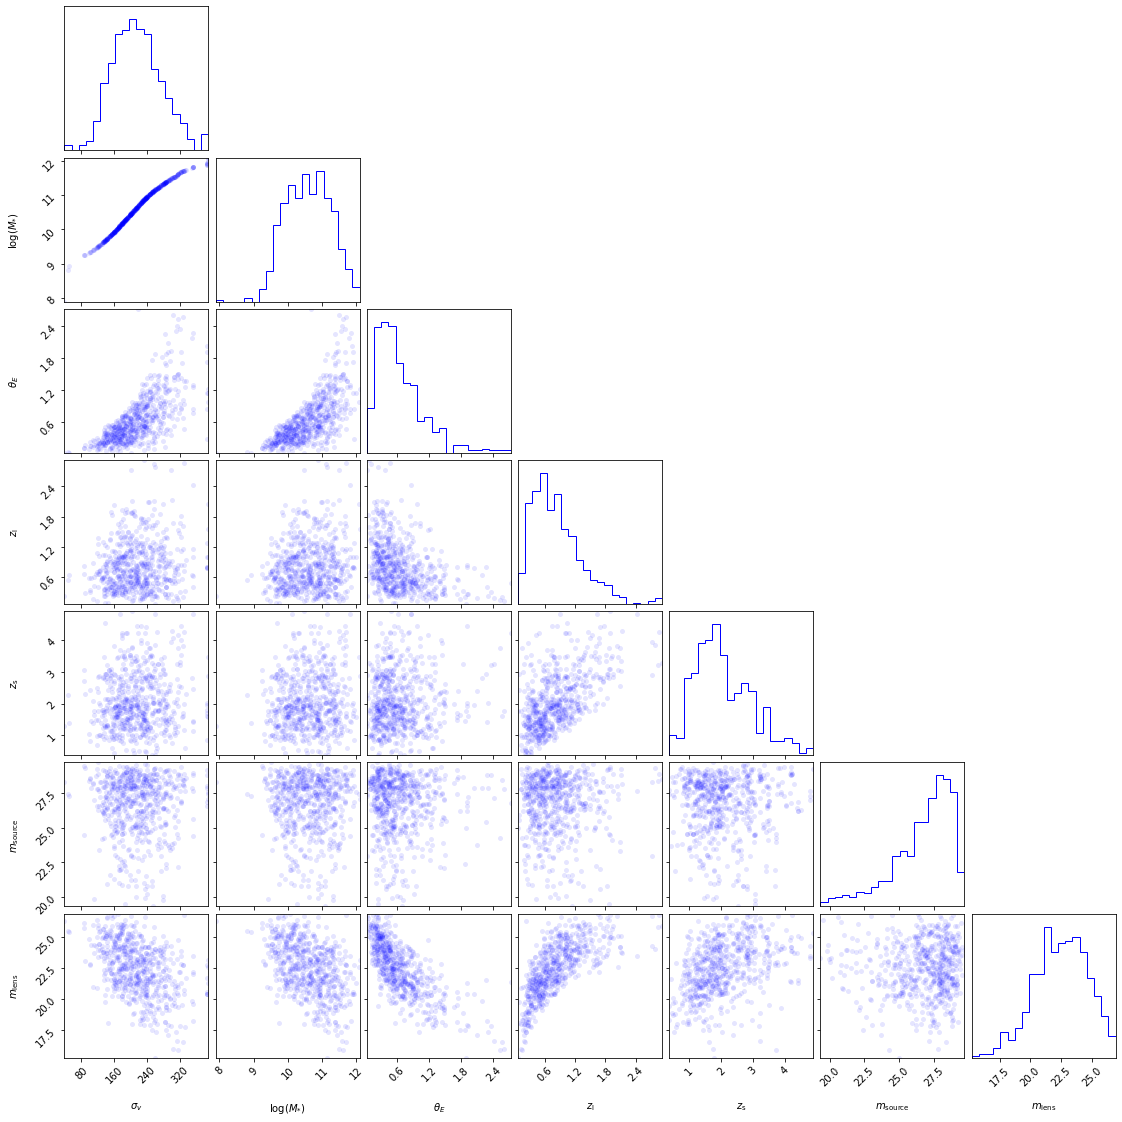

In [13]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples2), labels=labels, **hist2dkwargs)
plt.show()

## Apply some cuts

In [14]:
source_cut=[]
deflector_cut=[]
for i in range(len(source_z)):
    if m_s[i] <=24.9:
        source_cut.append(source_z[i])
        deflector_cut.append(deflector_z[i])

In [22]:
len(source_cut)

109

In [16]:
unlensed_source_cut=[]
for i in range(len(total_source)):
    if total_source["ps_mag_i"][i] <=24.9:
        unlensed_source_cut.append(total_source["z"][i])

## Plot lensed source, unlensed source, and deflector distribution.

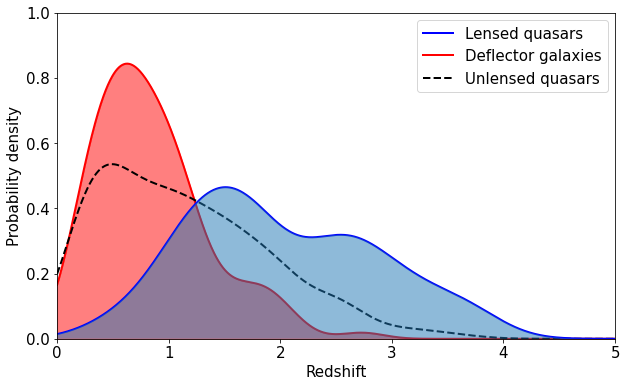

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Compute the KDE
kde_source = gaussian_kde(source_cut)
x_vals_source = np.linspace(0, 5, 1000)
kde_vals_source = kde_source(x_vals_source)
kde_deflector = gaussian_kde(deflector_cut)
x_vals_deflector = np.linspace(0, 5, 1000)
kde_vals_deflector = kde_deflector(x_vals_deflector)

kde_unlensed_supernovae = gaussian_kde(unlensed_source_cut, bw_method=0.3)
x_vals_unlensed_supernovae = np.linspace(0, 5, 1000)
kde_vals_unlensed_supernovae = kde_unlensed_supernovae(x_vals_unlensed_supernovae)

# Plot the KDE
plt.figure(figsize=(10, 6))
plt.plot(x_vals_source, kde_vals_source, color='blue', lw=2, zorder=2, label=r"Lensed quasars")
plt.fill_between(x_vals_source, kde_vals_source, alpha=0.5, zorder=2)
plt.plot(x_vals_deflector, kde_vals_deflector, color='red', lw=2, zorder=1, label=r"Deflector galaxies")
plt.fill_between(x_vals_deflector, kde_vals_deflector,color="red", alpha=0.5, zorder=1)
plt.plot(x_vals_unlensed_supernovae, kde_vals_unlensed_supernovae, ls="--", color='black', 
         lw=2, zorder=1, label=r"Unlensed quasars")
#plt.title('Probability Distribution of Redshift')
plt.xlabel('Redshift', fontsize=15)
plt.ylabel('Probability density', fontsize=15)
plt.xlim(0, 5)
plt.ylim(0,1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()